## Packages

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def load_data(path):
    train_dataset = h5py.File(path+'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(path+'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## Dataset

To be familiar with the dataset, load the data by running the cell below.

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data('D:/Ali Arda/dataset') # you need to change your dataset path

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


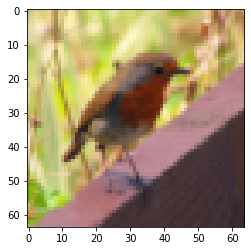

In [4]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [7]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [8]:
def initialize_parameters_deep(n_x,n_h,n_y):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":
    """
    
    np.random.seed(3)
    parameters = {}
    layer_dims = (n_x,n_h,n_y)
    L = len(layer_dims)            # number of layers in the network

    parameters["W1"] = np.random.normal(0.0,pow(n_h,-0.5),(n_h,n_x))
    parameters["b1"] = np.zeros((n_h,1))
    parameters["W2"] = np.random.normal(0.0,pow(n_y,-0.5),(n_y,n_h))
    parameters["b2"] = np.zeros((n_y,1))
    
    return parameters

In [9]:
def linear_activation_forward(X,parameters):
    """
    Implement the forward propagation

    Arguments:
    X -- input data:
    parameters -- python dictionary containing your parameters "W1", "b1","W2", "b2":

    Returns:
    AL -- output of the forward propogation
    """
     
    Z1 = np.dot(parameters["W1"],X) + parameters["b1"]
    A = np.tanh(Z1)
    Z2 = np.dot(parameters["W2"],A) + parameters["b2"]
    AL = (1)/(1+np.exp(-Z2))
    
    
    return AL 

In [10]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cost
    """
    m = Y.shape[1]
    cost = -np.mean(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    
    return cost

In [11]:
def linear_activation_backward(X,cost,parameters):
    """
    Implement the backward propagation
    
    Arguments:
    X -- input data
    cost -- cost
    
    Returns:
    grads --  A dictionary with the gradients
             grads["dW1"]
             grads["db1"]
             grads["dW2"]
             grads["db2"]
    """

    
    grads = {}
    m = X.shape[1]
    dZ1 = np.dot(np.transpose(parameters['W2']), cost) * (1-np.power(np.tanh(np.dot(parameters["W1"],X)+parameters["b1"]), 2))
    grads["dW1"] = ((np.sum(dZ1))/m).reshape(1,1)
    grads["db1"] = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    grads["dW2"] = (1 / m) * np.dot(cost, np.transpose(np.tanh(np.dot(parameters["W1"],X))+parameters["b1"]))
    grads["db2"] = ((np.sum(cost))/m).reshape(1,1)
    

    
    return grads

In [12]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
             parameters["W1"]
             parameters["b1"]
             parameters["W2"]
             parameters["b2"]
    """
    
    parameters["W1"] = parameters["W1"] - learning_rate*grads["dW1"]
    parameters["W2"] = parameters["W2"] - learning_rate*grads["dW2"]
    parameters["b1"] = parameters["b1"] - learning_rate*grads["db1"]
    parameters["b2"] = parameters["b2"] - learning_rate*grads["db2"]

    return parameters

In [13]:
def predict(test_x, test_y, parameters):
    """
    Predict test data
    test_x -- test data
    test_y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
    
    Returns:
    accuracy -- accuracy of your model
    
    """
    
    m = test_x.shape[1]
    prediction = np.zeros((1,m))
    n = len(parameters) // 2
    
    sigmo = linear_activation_forward(test_x,parameters)
    
    for i in range(0, sigmo.shape[1]):
        if sigmo[0,i] > 0.5:
            prediction[0,i] = 1
        else:
            prediction[0,i] = 0
            
    accuracy = np.sum((prediction == test_y)/m)
    
    
    
    return accuracy

In [14]:
def plot_loss(costs):
    """
    Plot loss
    costs - cost of each iteration
    
    """ 
    plt.plot(np.squeeze(costs))
    plt.ylabel("costs")
    plt.xlabel("costs of each iteration")
    plt.show()
    

    

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters_deep(n_x,n_h,n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### 
        AL = linear_activation_forward(X,parameters)
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### 
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
        
        
        # Backward propagation.
        ### START CODE HERE ### 
        grads = linear_activation_backward(X,cost,parameters)
        ### END CODE HERE ###

        
        # Update parameters.
        ### START CODE HERE ### 
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
        
        # Print the cost every 100 training example
        if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)


    return parameters, costs

In [16]:
def main():
    """Main function
    You need to combine all functions in the main function"""
    parameters , costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y),learning_rate = 0.00075, num_iterations = 2500)
    plot_loss(costs)
    accuracy_of_train = predict(train_x,train_y,parameters)
    print("accuracy of train is:", accuracy_of_train)
    
    

    

Cost after iteration 0: 1.0171229412262568
Cost after iteration 100: 0.9594078929410484
Cost after iteration 200: 0.9386993446101615
Cost after iteration 300: 0.9335214164102076
Cost after iteration 400: 0.9340570057417131
Cost after iteration 500: 0.934762446538063
Cost after iteration 600: 0.9354646142213663
Cost after iteration 700: 0.9361420513015795
Cost after iteration 800: 0.9368024069172267
Cost after iteration 900: 0.9374539893117708
Cost after iteration 1000: 0.9381016860357566
Cost after iteration 1100: 0.9387479310795883
Cost after iteration 1200: 0.9393938889628805
Cost after iteration 1300: 0.9400401244867893
Cost after iteration 1400: 0.9406869199794465
Cost after iteration 1500: 0.9413344206250044
Cost after iteration 1600: 0.9419827026381807
Cost after iteration 1700: 0.9426318065828523
Cost after iteration 1800: 0.9432817542773009
Cost after iteration 1900: 0.9439325576002123
Cost after iteration 2000: 0.9445842231475412
Cost after iteration 2100: 0.9452367547116332
C

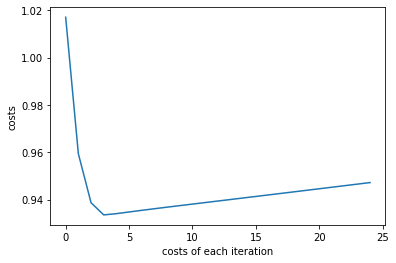

accuracy of train is: 0.6555023923444976


In [17]:
main()